In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
import h5py

from keras.layers import Input, Dense
from keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import BoundaryNorm
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

plt.rc('font', size=20)
plt.rc('font', family = 'serif')

In [11]:
h5_filename = 'npfiles/jet_data.h5'
substructure_variables = ['pT', 'w', 'q', 'm', 'r', 'tau2s', 'tau21', 'zg', 'mult', 'sdm']
data_streams = ['_true', '_true_alt', '_reco', '_reco_alt']
n_variables = len(substructure_variables)

normalize = False

In [1]:
data_dict = {}
with h5py.File(h5_filename, 'r') as data:
    for var_name in data.keys():
        data_dict[var_name] = data[var_name][:150000]


if normalize:
    for var_name in substructure_variables:
        key = f"{var_name}{data_streams[0]}"
        mu = np.mean(data_dict[key])
        sigma = np.std(data_dict[key])
                
        for stream in data_streams:
            stream_key = f"{var_name}{stream}"
            data_dict[stream_key] = (data_dict[stream_key] - mu) / sigma

NameError: name 'h5py' is not defined

In [14]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * (1 - y_pred))
    return K.mean(t_loss)

## Gaussian

In [ ]:
x_true = np.random.normal(0,1,100000)
x_true_alt = np.random.normal(-0.5,1,100000)

In [ ]:
xvals = np.concatenate([x_true_alt,x_true])
yvals = np.concatenate([np.ones(len(x_true_alt)),np.zeros(len(x_true))])

In [ ]:
#mean
low1 = -1
high1 = .5
step1 = 10
low2 = -1
high2 = .5
step2 = 10

losses1 = []
for lambda1 in np.linspace(low1, high1, step1):
    print(lambda1)
    losses2 = []
    for lambda2 in np.linspace(low2, high2, step2):
        weights = np.concatenate([np.ones(len(x_true_alt)),np.exp(lambda1*x_true + lambda2*x_true**2)*len(x_true_alt)/np.sum(np.exp(lambda1*x_true + lambda2*x_true**2))])
        X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(xvals, yvals, weights)

        Y_train_2 = np.stack((Y_train, w_train), axis=1)
        Y_test_2 = np.stack((Y_test, w_test), axis=1)

        inputs = Input((1, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
        model = Model(inputs=inputs, outputs=outputs)
    
        model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
        model.fit(X_train,
              Y_train_2,
              epochs=3,
              batch_size=1000,
              verbose=0)

        losses2 +=[model.history.history['loss'][-1]]
    losses1 += [losses2]

In [ ]:
a = -500

y = np.linspace(low1, high1, step1)
x = np.linspace(low2, high2, step2)
X,Y = np.meshgrid(x,y)
Z = np.array(losses1)
Z = gaussian_filter(Z, sigma=1.)

X_fine = np.linspace(X.min(), X.max(), 300)
Y_fine = np.linspace(Y.min(), Y.max(), 300)
X_fine, Y_fine = np.meshgrid(X_fine, Y_fine)
Z_fine = griddata((X.flatten(), Y.flatten()), Z.flatten(), (X_fine, Y_fine), method='cubic')


fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim(-1, 0.25)
#ax.set_aspect('equal')
ax.set_xlabel(r'$\beta_2$')
ax.set_ylabel(r'$\beta_1$')


cf = ax.contourf(X_fine, Y_fine, Z_fine, 100, cmap='Greens_r', vmin = -0.03, vmax = Z_fine.max())

clb = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
clb.ax.set_title('Loss')
clb.ax.set_ylim(-0.04, Z_fine.max())
clb.ax.set_yticks(np.linspace(-0.04, Z_fine.max(), 6))
clb.ax.set_yticklabels(np.round(np.linspace(-0.04, Z_fine.max(), 6), 2))

ellipse = Ellipse(xy=(-0.15, -.5), width=0.0716284, height=0.071431, 
                        edgecolor='None', fc='blue', alpha = 0.5, label="Learned values")
ax.add_patch(ellipse)
plt.scatter([-0.1569230769230771], [-0.5], c='r', marker='*', label="Numerical max")
plt.legend()
plt.title("Gaussian Data: Loss Landscape")
plt.savefig("figures/gaussloss.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Mass

In [ ]:
x_true = m_true
x_true_alt = m_true_alt

In [ ]:
xvals = np.concatenate([x_true_alt,x_true])
yvals = np.concatenate([np.ones(len(x_true_alt)),np.zeros(len(x_true))])

In [ ]:
#mean
low1 = -9
high1 = -5
step1 = 10
low2 = -7.5
high2 = -4
step2 = 10

losses1 = []
for lambda1 in np.linspace(low1, high1, step1):
    print(lambda1)
    losses2 = []
    for lambda2 in np.linspace(low2, high2, step2):
        weights = np.concatenate([np.ones(len(x_true_alt)),np.exp(lambda1*x_true + lambda2*x_true**2)*len(x_true_alt)/np.sum(np.exp(lambda1*x_true + lambda2*x_true**2))])
        X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(xvals, yvals, weights)

        Y_train_2 = np.stack((Y_train, w_train), axis=1)
        Y_test_2 = np.stack((Y_test, w_test), axis=1)

        inputs = Input((1, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
        model = Model(inputs=inputs, outputs=outputs)
    
        model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
        model.fit(X_train,
              Y_train_2,
              epochs=10,
              batch_size=100,
              verbose=0)

        losses2 +=[model.history.history['loss'][-1]]
    losses1 += [losses2]
    #print(f"{lambda1 = }, loss = {losses1[-1]}")

In [ ]:
#np.save('npfiles/mloss', losses1)
losses1 = np.load('npfiles/mloss.npy')

In [ ]:
#mean
low1 = -9
high1 = -5
step1 = 10
low2 = -7.5
high2 = -4
step2 = 10

In [ ]:
y = np.linspace(low1, high1, step1)
x = np.linspace(low2, high2, step2)
X,Y = np.meshgrid(x,y)
Z = np.array(losses1)

fig, ax = plt.subplots(figsize=(8,8))

X_fine = np.linspace(X.min(), X.max(), 300)
Y_fine = np.linspace(Y.min(), Y.max(), 300)
X_fine, Y_fine = np.meshgrid(X_fine, Y_fine)
Z_fine = griddata((X.flatten(), Y.flatten()), Z.flatten(), (X_fine, Y_fine), method='cubic')


ax.set_xlim(-4.8, -4)
ax.set_ylim(-6.8, -6)
#ax.set_aspect('equal')
ax.set_xlabel(r'$\beta_2$')
ax.set_ylabel(r'$\beta_1$')
cf = ax.contourf(X_fine, Y_fine, Z_fine, 25, cmap='Greens_r', vmin=-0.5)
clb = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
clb.ax.set_title('Loss')
ellipse = Ellipse(xy=(-4.39, -6.33), width=0.0516284, height=0.051431, 
                        edgecolor='None', fc='blue', alpha = 0.5, label="Learned values")
ax.add_patch(ellipse)
plt.scatter(-4.39, -6.33, c='r', marker='*', label="Numerical max")
plt.legend()
plt.title("Jet Mass: Loss Landscape")
plt.savefig("figures/mjetloss.pdf", bbox_inches='tight', transparent=True)

## Charge

In [ ]:
x_true = q_true
x_true_alt = q_true_alt

In [ ]:
xvals = np.concatenate([x_true_alt,x_true])
yvals = np.concatenate([np.ones(len(x_true_alt)),np.zeros(len(x_true))])

In [ ]:
#mean
high1 = 2
low1 = -2
step1 = 25
low2 = -20
high2 = 2
step2 = 25

losses1 = []
for lambda1 in np.linspace(low1, high1, step1):
    print(lambda1)
    losses2 = []
    for lambda2 in np.linspace(low2, high2, step2):
        weights = np.concatenate([np.ones(len(x_true_alt)),np.exp(lambda1*x_true + lambda2*x_true**2)*len(x_true_alt)/np.sum(np.exp(lambda1*x_true + lambda2*x_true**2))])
        X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(xvals, yvals, weights)

        Y_train_2 = np.stack((Y_train, w_train), axis=1)
        Y_test_2 = np.stack((Y_test, w_test), axis=1)

        inputs = Input((1, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
        model = Model(inputs=inputs, outputs=outputs)
    
        model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
        model.fit(X_train,
              Y_train_2,
              epochs=3,
              batch_size=1000,
              verbose=0)

        losses2 +=[model.history.history['loss'][-1]]
    losses1 += [losses2]
    #print(f"{lambda1 = }, loss = {losses1[-1]}")

In [ ]:
#np.save('npfiles/qlosses', losses1)
losses1 = np.load('npfiles/qlosses.npy')

In [ ]:
high1 = 2
low1 = -2
step1 = 25
low2 = -20
high2 = 2
step2 = 25

y = np.linspace(low1, high1, step1)
x = np.linspace(low2, high2, step2)
X,Y = np.meshgrid(x,y)
Z = np.array(losses1)
Z = gaussian_filter(Z, sigma=1.)

X_fine = np.linspace(X.min(), X.max(), 800)
Y_fine = np.linspace(Y.min(), Y.max(), 800)
X_fine, Y_fine = np.meshgrid(X_fine, Y_fine)
Z_fine = griddata((X.flatten(), Y.flatten()), Z.flatten(), (X_fine, Y_fine), method='cubic')

fig, ax = plt.subplots(figsize=(8,8))


#ax.set_aspect('equal')
ax.set_xlabel(r'$\beta_2$')
ax.set_ylabel(r'$\beta_1$')
cf = ax.contourf(X_fine, Y_fine, Z_fine, 30, cmap='Greens_r', vmin=-0.007)
clb = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
clb.ax.set_title('Loss')
ellipse = Ellipse(xy=(-6, -0.3), width=1.5988884, height=0.15031329, 
                        edgecolor='None', fc='blue', alpha = 0.5, label="Learned values")
ax.add_patch(ellipse)
clb.ax.set_ylim(-0.012, Z_fine.max())
clb.ax.set_yticks(np.linspace(-0.012, Z_fine.max(), 6))
clb.ax.set_yticklabels(np.round(np.linspace(-0.012, Z_fine.max(), 6), 3))
plt.scatter([-6.09387755], [-0.3122449], c='r', marker='*', label="Numeric max")
plt.legend()
plt.title("Jet Charge: Loss Landscape")
plt.savefig("figures/qjetloss.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Width

In [ ]:
x_true = w_true
x_true_alt = w_true_alt

In [ ]:
xvals = np.concatenate([x_true_alt,x_true])
yvals = np.concatenate([np.ones(len(x_true_alt)),np.zeros(len(x_true))])

In [ ]:
#mean
low1 = 14
high1 = 20.
step1 = 7
low2 = 16
high2 = 20
step2 = 7

losses1 = []
for lambda1 in np.linspace(low1, high1, step1):
    losses2 = []
    print(lambda1)
    for lambda2 in np.linspace(low2, high2, step2):
        weights = np.concatenate([np.ones(len(x_true_alt)),np.exp(lambda1*x_true + lambda2*x_true**2)*len(x_true_alt)/np.sum(np.exp(lambda1*x_true + lambda2*x_true**2))])
        X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(xvals, yvals, weights)

        Y_train_2 = np.stack((Y_train, w_train), axis=1)
        Y_test_2 = np.stack((Y_test, w_test), axis=1)

        inputs = Input((1, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
        model = Model(inputs=inputs, outputs=outputs)
    
        model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
        model.fit(X_train,
              Y_train_2,
              epochs=3,
              batch_size=1000,
              verbose=0)

        losses2 +=[model.history.history['loss'][-1]]
    losses1 += [losses2]
    #print(f"{lambda1 = }, loss = {losses1[-1]}")

In [ ]:
#np.save("npfiles/wlosses", losses1)

In [ ]:
losses1 = np.load("npfiles/wlosses.npy")
low1 = 14
high1 = 20.
step1 = 7
low2 = 16
high2 = 20
step2 = 7

In [ ]:
y = np.linspace(low1, high1, step1)
x = np.linspace(low2, high2, step2)
X,Y = np.meshgrid(x,y)
Z = np.array(losses1)

Z = gaussian_filter(Z, sigma=0.)

X_fine = np.linspace(X.min(), X.max(), 800)
Y_fine = np.linspace(Y.min(), Y.max(), 800)
X_fine, Y_fine = np.meshgrid(X_fine, Y_fine)
Z_fine = griddata((X.flatten(), Y.flatten()), Z.flatten(), (X_fine, Y_fine), method='cubic')

plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(figsize=(8, 8))


#ax.set_aspect('equal')
ax.set_xlabel(r'$\beta_2$')
ax.set_ylabel(r'$\beta_1$')
cf = ax.contourf(X_fine, Y_fine, Z_fine, 20, cmap='Greens_r', vmin = -0.46)
clb = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
clb.ax.set_title('Loss')

ax.set_xlim(17, 19)

ax.set_ylim(16.5, 18.5)
#ax.set_yticks(np.linspace(16, 20, 5))
ellipse = Ellipse(xy=(18., 17.8), width=0.15988884, height=0.15031329, 
                        edgecolor='None', fc='blue', alpha = 0.5, label="Learned values")
ax.add_patch(ellipse)
plt.scatter(18., 17.85, c='r', marker='*', label="Numeric max")
plt.legend()
plt.title("Jet Width: Loss Landscape")
plt.savefig("figures/wjetloss.pdf", bbox_inches='tight', transparent=True)

## Z_g

In [15]:
x_true = data_dict['zg_true']
x_true_alt = data_dict['zg_true_alt']

In [16]:
xvals = np.concatenate([x_true_alt,x_true])
yvals = np.concatenate([np.ones(len(x_true_alt)),np.zeros(len(x_true))])

In [52]:
#np.save('npfiles/zglosses', losses1)
losses1 = np.load('npfiles/zglosses.npy')

In [31]:
#mean
low1 = 4
high1 = 6
step1 = 7
low2 = 2
high2 = 4
step2 = 7

losses1 = []
for lambda1 in np.linspace(low1, high1, step1):
    losses2 = []
    print(lambda1)
    for lambda2 in np.linspace(low2, high2, step2):
        weights = np.concatenate([np.ones(len(x_true_alt)),np.exp(lambda1*x_true + lambda2*x_true**2)*len(x_true_alt)/np.sum(np.exp(lambda1*x_true + lambda2*x_true**2))])
        X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(xvals, yvals, weights)

        Y_train_2 = np.stack((Y_train, w_train), axis=1)
        Y_test_2 = np.stack((Y_test, w_test), axis=1)

        inputs = Input((1, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
        model = Model(inputs=inputs, outputs=outputs)
    
        model.compile(loss=weighted_binary_crossentropy, optimizer='Adam', metrics=['accuracy'])
        model.fit(X_train,
              Y_train_2,
              epochs=3,
              batch_size=1000,
              verbose=0)

        losses2 +=[model.history.history['loss'][-1]]
    losses1 += [losses2]
    #print(f"{lambda1 = }, loss = {losses1[-1]}")

4.0
4.333333333333333
4.666666666666667
5.0
5.333333333333333
5.666666666666666
6.0


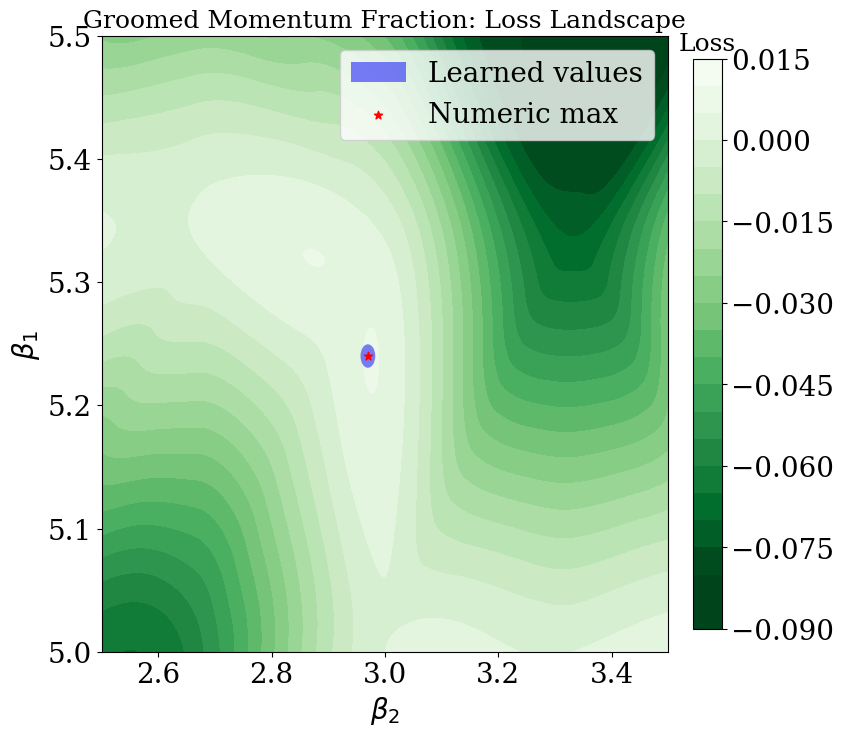

In [51]:
y = np.linspace(low1, high1, step1)
x = np.linspace(low2, high2, step2)
X,Y = np.meshgrid(x,y)
Z = np.array(losses1)

Z = gaussian_filter(Z, sigma=0.)

X_fine = np.linspace(X.min(), X.max(), 800)
Y_fine = np.linspace(Y.min(), Y.max(), 800)
X_fine, Y_fine = np.meshgrid(X_fine, Y_fine)
Z_fine = griddata((X.flatten(), Y.flatten()), Z.flatten(), (X_fine, Y_fine), method='cubic')

plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(figsize=(8, 8))


#ax.set_aspect('equal')
ax.set_xlabel(r'$\beta_2$')
ax.set_ylabel(r'$\beta_1$')
cf = ax.contourf(X_fine, Y_fine, Z_fine, 20, cmap='Greens_r', vmin=-0.08)
clb = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
clb.ax.set_title('Loss', fontsize = 18)

ax.set_xlim(2.5, 3.5)

ax.set_ylim(5, 5.5)
#ax.set_yticks(np.linspace(16, 20, 5))
ellipse = Ellipse(xy=(2.97, 5.24), width=0.025988884, height=0.019031329, 
                        edgecolor='None', fc='blue', alpha = 0.5, label="Learned values")
ax.add_patch(ellipse)
plt.scatter(2.97, 5.24, c='r', marker='*', label="Numeric max")
plt.legend()
plt.title("Groomed Momentum Fraction: Loss Landscape", fontsize = 18)
plt.savefig("figures/zgjetloss.pdf", bbox_inches='tight', transparent=True)